# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__
1) Which living outcome do housing conditions affect the most (education, health or happiness)?

2) Is there a correlation between precarious housing and health (both physical and mental) status?

3) In what ways do living conditions affect children scholarship (if they do) ? Which age group is most impacted ?


## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from math import exp, log
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms


In [2]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [3]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','RESPID','UCPSID','SEX','UAGE','SITE','STATE','UREGION','TYPEINT','HHID']
household_id_hh = ['HHID']
education = ['UENG','UENGNEG','UENGPOS','NLESSONS']
#family = ['GHMAD','GSELFHR','UFAMSTR','UMH2','UMHIGDEG']
family = ['UFAMSTR','UMH2','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS']
health = ['BDISBL','BHLTHN','FDOCT','FWHMED','FWHYMED','FDENT','FWELLV','UCNGHL']
activities = ['NOUTING','NSPORTS','UOUTNEG','UOUTPOS','UACT','UACTNEG','UACTPOS']
programs = ['GCENTR','CSPECED','CAGRAD','GHEADS','KAPPMED','SSHELP']
eco = ['CJOB','UHINS4'] #NB CJOB only for fc3

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + programs + eco]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh]

In [4]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the CJOB variable binary with Yes=1 and No=0
child['CJOB'].replace(2,0,inplace=True)
# Make the NLESSONS variable binary with Yes=1 and No=0
child['NLESSONS'].replace(2,0,inplace=True)
# Make the QSC5 variable (hh income vs 2x poverty line) binary with Below=0 and Above=1
child['QSC5'].replace({'1':0,'2':1,'':-1}, inplace=True)

# Normalize values for UENG(4-16), BHLTHN(1-5), UBPIA(6-18) & UBPIB(6-18) (min-max)
child.loc[:,'UENGn'] = child['UENG'].apply(lambda x: (x-4)/(16-4) if x != -1 else x)
child.loc[:,'BHLTHNn'] = child['BHLTHN'].apply(lambda x: (x-1)/(5-1) if x != -1 else x)
child.loc[:,'UBPIAn'] = child['UBPIA'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UBPIBn'] = child['UBPIB'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,CHLD6_17,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn
0,5561612801,1,5561612803,5561612800,1,3,15,WI,2,A1,...,0,3,0,4,1,0.75,-1.000000,0.00,-1.0,-1.000000
1,5470400001,2,5470400003,5470400000,0,14,15,WI,2,A1,...,2,3,1,2,2,1.50,0.333333,0.00,-1.0,0.416667
2,5787427204,2,5787427205,5787427200,1,9,15,WI,2,A1,...,4,6,0,3,2,2.00,0.666667,0.50,1.0,-1.000000
3,5410681601,1,5410681604,5410681600,0,4,15,WI,2,A1,...,0,5,0,2,2,2.50,-1.000000,0.25,-1.0,-1.000000
4,5051721601,2,5051721605,5051721600,1,17,15,WI,2,A1,...,4,5,0,4,2,1.25,0.750000,0.25,-1.0,0.833333


In [5]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# are there young children (0-5yo) in household?
child.loc[:,'bool0_5'] = child['CHLD0_5'].apply(lambda x : 0 if x == 0 else 1)

# FC1 : focal child, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal child, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal child, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal child, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [6]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 61)
fc2: (10925, 61)
fc3:(11087, 61)
fc23: (22012, 61)
True


## Propensity score attempt

__Living conditions indicator :__

In [7]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [8]:
# Variables used for precarity indicator (economics and relationship with family)
# NB CHOICE OF WORDS : PRECARITY NOT VERY ACCURATE
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']
#prec3 = prec + ['CJOB']

df_prec = df_NN(fc23,'PERSID',prec)
#df_prec_3 = df_NN(fc3,'PERSID',prec3)

In [9]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
#negative3 = negative + ['CJOB']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them -> WE CAN CHOOSE WEIGHTS LATER TO TUNE THE INDEX
# NB performs column-wise automatically
norm_prec =(df_prec[prec]-df_prec[prec].min())/(df_prec[prec].max()-df_prec[prec].min())
#norm_prec_3 =(df_prec_3[prec3]-df_prec_3[prec3].min())/(df_prec_3[prec3].max()-df_prec_3[prec3].min())
norm_prec.loc[:,negative] *= -1
#norm_prec_3.loc[:,negative3] *= -1

# Compute living conditions indicator
norm_prec.loc[:,'living_ind'] = norm_prec.sum(axis=1)
#norm_prec_3.loc[:,'living_ind'] = norm_prec_3.sum(axis=1)

In [10]:
# Choose a threshold to consider a household 'precarious' or not -> ADAPT (j'ai juste pris zero en mode random)
norm_prec.loc[:,'precarious'] = norm_prec['living_ind'].apply(lambda x : 1 if x < 1 else 0)
#norm_prec_3.loc[:,'precarious'] = norm_prec_3['living_ind'].apply(lambda x : 1 if x < 1 else 0)

# Merge this new column with whole df without NaNs
fc23_prec = pd.merge(fc23, norm_prec['precarious'], left_index=True, right_index=True, how='inner')
#fc3_prec = pd.merge(fc3, norm_prec_3['precarious'], left_index=True, right_index=True, how='inner')

In [11]:
fc23_prec.head()

,PERSID,PERSTYPE,RESPID,UCPSID,SEX,UAGE,SITE,STATE,UREGION,TYPEINT,...,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,bool0_5,precarious
1,5470400001,2,5470400003,5470400000,0,14,15,WI,2,A1,...,1,2,2,1.50,0.333333,0.00,-1.0,0.416667,0,0
2,5787427204,2,5787427205,5787427200,1,9,15,WI,2,A1,...,0,3,2,2.00,0.666667,0.50,1.0,-1.000000,0,1
4,5051721601,2,5051721605,5051721600,1,17,15,WI,2,A1,...,0,4,2,1.25,0.750000,0.25,-1.0,0.833333,0,1
6,5353539201,2,5353539204,5353539200,1,11,15,WI,2,A1,...,1,4,2,2.25,1.000000,0.50,0.5,-1.000000,1,1
8,5065766401,2,5065766404,5065766400,1,14,15,WI,2,A1,...,0,2,2,2.00,0.416667,0.50,-1.0,0.083333,0,1


**PS with `bool0_5` as a treatment**

In [12]:
# logistic regression for CHLD0_5
# NB changed to fc23 rather than child, removed BHLTHN from PS calculation
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS','MOWNRENT','OVERCROWDING','BDISBL','UHINS4']
df_05 = df_NN(fc23,'bool0_5',predictors)

log_model_1 = 'bool0_5 ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + UHINS4'

log1 = smf.logit(formula=log_model_1, data=df_05)
res1 = log1.fit()

Optimization terminated successfully.
         Current function value: 0.497099
         Iterations 6


In [13]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bool0_5   No. Observations:                21474
Model:                          Logit   Df Residuals:                    21458
Method:                           MLE   Df Model:                           15
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                  0.1658
Time:                        11:51:28   Log-Likelihood:                -10675.
converged:                       True   LL-Null:                       -12796.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.0937      0.230    -17.776      0.000      -4.545      -3.642
UREGION[T.2]    -0.0165      0.049     -0.337      0.736      -0.112       0.079
UREGION[T.3]     0.0189      0.049      0.382      0.703      -0.078       0.116
UREGION[T.4]    -0.0047      0.051     -0.093      0.926      -0.105       0.095
SEX              0.0023      0.034      0.066      0.947      -0.064       0.069
UFAMSTR         -0.0114      0.020     -0.577      0.564      -0.050       0.027
UMH2             0.0064      0.001      4.616      0.000       0.004       0.009
UMHIGDEG        -0.0246      0.009     -2.703      0.007      -0.042      -0.007
UAGG            -0.0287      0.010     -2.963      0.003      -0.048      -0.010
UHHCOUNT         0.7318      0.029     25.354      0.000       0.675       0.788
U_SOCPOV        -0.2043      0.018    -11.652      0.000      -0.239      -0.170
MNBEDRMS        -0.1541      0.041     -3.772      0.000      -0.234      -0.074
MOWNRENT         0.2300      0.039      5.965      0.000       0.154       0.306
OVERCROWDING     0.2760      0.071      3.909      0.000       0.138       0.414
BDISBL           0.2687      0.054      5.008      0.000       0.164       0.374
UHINS4          -0.0875      0.020     -4.332      0.000      -0.127      -0.048
================================================================================
"""

In [14]:
pred05 = res1.predict(df_05)
df_05.loc[:,'PS'] = pred05

//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### without matching

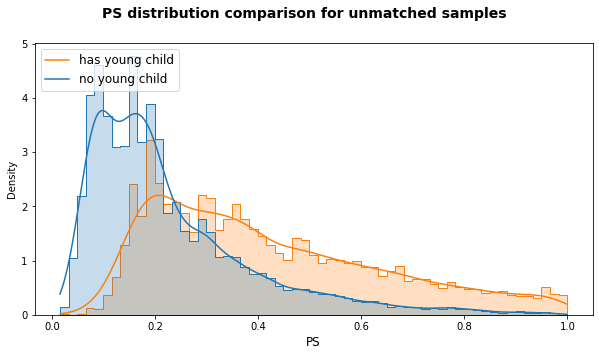

In [15]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_05, x="PS", hue='bool0_5', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

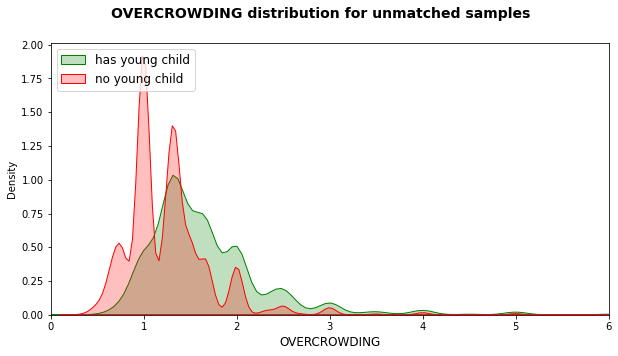

In [16]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_05, x=var, hue='bool0_5', palette=['r','g'], shade=True, common_norm=False)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

In [17]:
umh = df_05.groupby('bool0_5').mean()
print('Diff of mean = ' +str(umh['UMH2'][1] - umh['UMH2'][0]))

Diff of mean = 0.21907978074165158


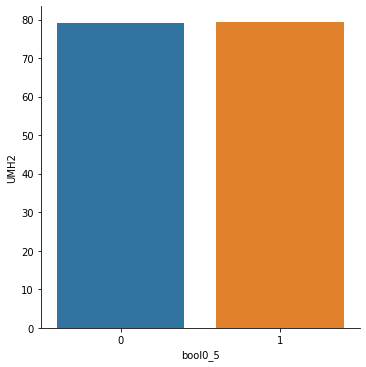

In [18]:
# not huge difference of about 0.33 -> could finish the conclusion by making bootstrap interval -> probably significant
sns.catplot(data=umh.reset_index(),x='bool0_5',y='UMH2',kind='bar')

#### with matching

In [19]:
# Finds closest PS to the input 'score' from the inputted array 'array'.
# Returns value of PS and its difference with 'score'.
def find_nearest(array, score):
    array = np.asarray(array)
    idx = (np.abs(array - score)).argmin()
    matchps = array[idx]
    return matchps, np.abs(matchps-score)

In [20]:
# Returns a dataframe containing two equally numbered populations (control, treatment) with ideally
# matched propensity scores
def optimatch(ctrl_df,trtm_df,alpha=0.01):
    idx=[]
    idtrtm=[]
    if (trtm_df.shape[0] > ctrl_df.shape[0]): # we iterate over the smaller dataframe and use the other one as a pool
        trtm_df, ctrl_df = ctrl_df, trtm_df
    iterative_df = trtm_df.reset_index(drop=True).copy().sample(frac=1) # shuffles the df so that we don't always preferentially optimize the first rows
    pool_df = ctrl_df.reset_index(drop=True).copy()
    for i in range(0,iterative_df.shape[0]):
        ps = iterative_df.iloc[i].PS
        matched, diff = find_nearest(pool_df.PS.drop(idx),ps)
        if (diff < alpha):
            idx.append(pool_df[pool_df.PS == matched].index[0]) 
            idtrtm.append(i)
    return pool_df.iloc[idx].append(iterative_df.iloc[idtrtm])

In [21]:
trtm0_5 = df_05[df_05.bool0_5 == 1].reset_index(drop=True)
ctrl0_5 = df_05[df_05.bool0_5 == 0].reset_index(drop=True)

# Perform matching between treated and non-treated samples
df_child05 = optimatch(trtm0_5,ctrl0_5,0.001)

print(f'Number of treated subjects (children) : {trtm0_5.shape[0]} \n\
Number of control subjects (no children) : {ctrl0_5.shape[0]} \n\
Number of matched pairs : {df_child05.shape[0]/2}')

Number of treated subjects (children) : 6080 
Number of control subjects (no children) : 15394 
Number of matched pairs : 5191.0


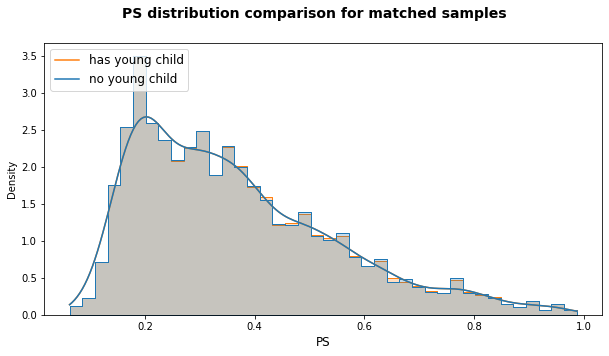

In [22]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_child05, x="PS", hue='bool0_5', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper left', fontsize = 12)
plt.show()

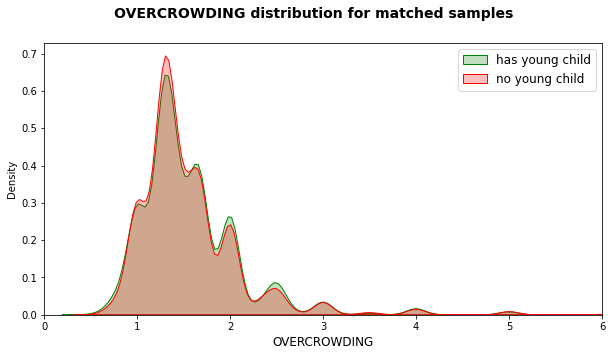

In [23]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_child05, x=var, hue='bool0_5', palette=['r','g'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['has young child','no young child'], loc='upper right', fontsize = 12)
plt.show()

# similar curves with matching ! bg!

In [24]:
means_child05 = df_child05.groupby('bool0_5').mean()
print('Diff of UMH2 mean = ' +str(means_child05['UMH2'][1] - means_child05['UMH2'][0]))
means_child05

Diff of UMH2 mean = -0.3089963398189184


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,NLESSONS,UFAMSTR,UMH2,UMHIGDEG,...,UHHCOUNT,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,PS
bool0_5,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.485841,12.157580,12.491427,0.217877,0.306877,0.316317,3.349066,79.652475,3.656328,...,4.748218,0.446735,3.274706,1.320362,1.548218,0.699528,0.192304,-0.233674,0.057600,0.367011
1,2.0,0.488730,9.513196,12.614332,0.200347,0.311308,0.320747,3.267386,79.343479,3.681757,...,4.720285,0.460990,3.236756,1.340589,1.565466,0.710669,0.180360,0.362615,-0.549541,0.367012


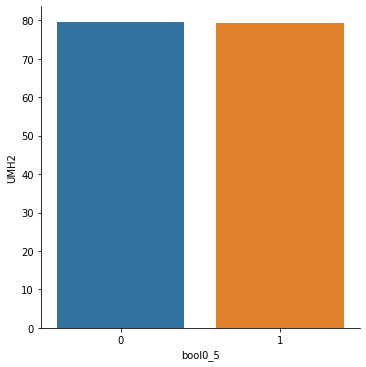

In [25]:
sns.catplot(data=means_child05.reset_index(),x='bool0_5',y='UMH2',kind='bar')

**PS with `NLESSONS` as treatment**

In [26]:
# logistic regression for NLESSONS
# NB removed BHLTHN
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS',
             'MOWNRENT','OVERCROWDING','BDISBL','CSPECED','UHINS4']
df_lessons = df_NN(fc23,'NLESSONS',predictors)

log_model_L = 'NLESSONS ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG + \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + CSPECED + UHINS4'

log_L = smf.logit(formula=log_model_L, data=df_lessons)
res_L = log_L.fit()
res_L.summary()

Optimization terminated successfully.
         Current function value: 0.599841
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               NLESSONS   No. Observations:                21287
Model:                          Logit   Df Residuals:                    21270
Method:                           MLE   Df Model:                           16
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                 0.06086
Time:                        11:51:43   Log-Likelihood:                -12769.
converged:                       True   LL-Null:                       -13596.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.5483      0.213    -16.649      0.000      -3.966      -3.131
UREGION[T.2]    -0.2664      0.043     -6.241      0.000      -0.350      -0.183
UREGION[T.3]    -0.3963      0.044     -8.937      0.000      -0.483      -0.309
UREGION[T.4]    -0.2156      0.045     -4.825      0.000      -0.303      -0.128
SEX              0.7415      0.031     24.298      0.000       0.682       0.801
UFAMSTR          0.1294      0.018      7.211      0.000       0.094       0.165
UMH2             0.0054      0.001      4.231      0.000       0.003       0.008
UMHIGDEG         0.0999      0.008     12.054      0.000       0.084       0.116
UAGG             0.0136      0.009      1.521      0.128      -0.004       0.031
UHHCOUNT        -0.0826      0.024     -3.381      0.001      -0.130      -0.035
U_SOCPOV         0.1780      0.016     10.840      0.000       0.146       0.210
MNBEDRMS         0.1346      0.033      4.029      0.000       0.069       0.200
MOWNRENT         0.0594      0.036      1.633      0.102      -0.012       0.131
OVERCROWDING    -0.0229      0.064     -0.360      0.719      -0.148       0.102
BDISBL           0.2089      0.059      3.562      0.000       0.094       0.324
CSPECED          0.1809      0.058      3.137      0.002       0.068       0.294
UHINS4          -0.0711      0.019     -3.831      0.000      -0.107      -0.035
================================================================================
"""

In [27]:
pred_L = res_L.predict(df_lessons)
df_lessons.loc[:,'PS'] = pred_L

//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


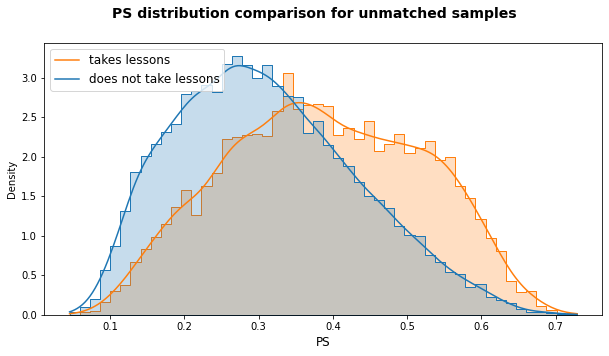

In [28]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_lessons, x="PS", hue='NLESSONS', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['takes lessons','does not take lessons'], loc='upper left', fontsize = 12)
plt.show()

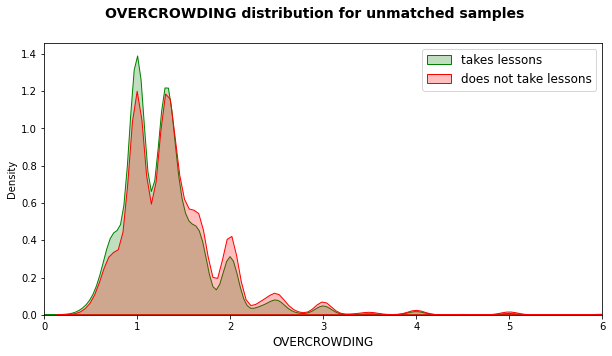

In [29]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_lessons, x=var, hue='NLESSONS', palette=['r','g'], shade=True, common_norm=False)
plt.xlim(0,6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['takes lessons','does not take lessons'], loc='upper right', fontsize = 12)
plt.show()

In [30]:
means_L = df_lessons.groupby('NLESSONS').mean()
print('Diff of mean = ' +str(means_L['UENGPOS'][1] - means_L['UENGPOS'][0]))
means_L

Diff of mean = 0.1037068124418421


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,UFAMSTR,UMH2,UMHIGDEG,UAGG,...,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,bool0_5,PS
NLESSONS,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.430716,11.630603,12.277207,0.251363,0.278482,3.120654,78.546484,3.568789,13.774552,...,0.469518,3.188133,1.317284,1.409017,0.682911,0.194559,-0.125475,-0.070547,0.293776,0.310641
1,2.0,0.609855,11.339754,13.144891,0.145729,0.382189,3.341709,80.778755,3.923227,13.988693,...,0.621859,3.364740,1.243439,1.308023,0.756782,0.150230,-0.041504,-0.119579,0.261725,0.387607


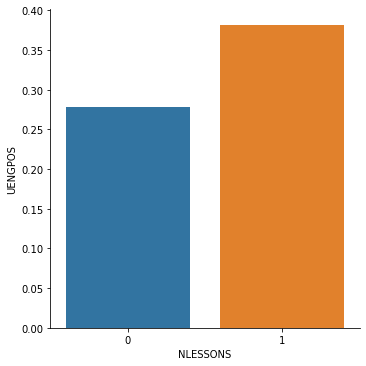

In [31]:
sns.catplot(data=means_L.reset_index(),x='NLESSONS',y='UENGPOS',kind='bar')

In [32]:
# Perform matching
trtm_L = df_lessons[df_lessons.NLESSONS == 1].sample(frac=1).reset_index(drop=True)
ctrl_L = df_lessons[df_lessons.NLESSONS == 0].sample(frac=1).reset_index(drop=True)

# Perform matching between treated and non-treated papers
df_L = optimatch(ctrl_L,trtm_L,0.001)

print(f'Number of treated subjects (lessons) : {trtm_L.shape[0]} \n\
Number of control subjects (no lessons) : {ctrl_L.shape[0]} \n\
Number of matched pairs : {df_L.shape[0]/2}')

Number of treated subjects (lessons) : 7164 
Number of control subjects (no lessons) : 14123 
Number of matched pairs : 6902.0


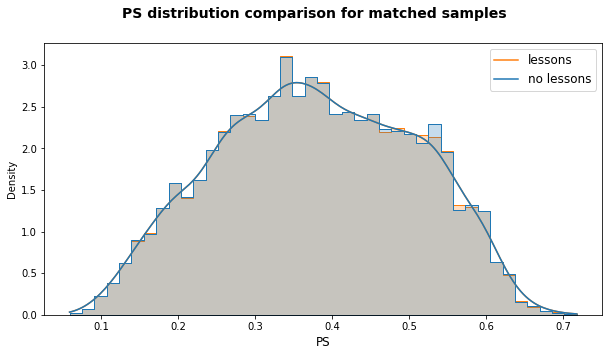

In [33]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_L, x="PS", hue='NLESSONS', kde=True, element='step', stat='density', 
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['lessons','no lessons'], loc='upper right', fontsize = 12)
plt.show()

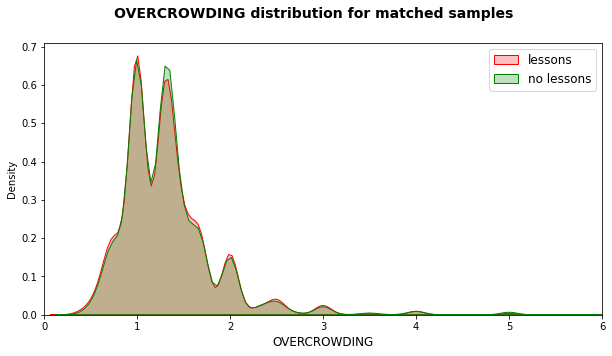

In [34]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_L, x=var, hue='NLESSONS', palette=['g','r'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['lessons','no lessons'], loc='upper right', fontsize = 12)
plt.show()

In [35]:
means_L = df_L.groupby('NLESSONS').mean()
print('Diff of mean = ' +str(means_L['UENGPOS'][1] - means_L['UENGPOS'][0]))
means_L

Diff of mean = 0.03897421037380472


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,UFAMSTR,UMH2,UMHIGDEG,UAGG,...,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,bool0_5,PS
NLESSONS,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.590698,11.760070,12.723269,0.197914,0.337438,3.341930,80.889307,3.883802,14.030716,...,0.587656,3.323095,1.246740,1.326899,0.720262,0.170784,-0.141734,-0.027335,0.262243,0.379667
1,2.0,0.595769,11.331643,13.111852,0.149087,0.376413,3.324688,80.579397,3.875978,13.968270,...,0.611272,3.335845,1.249928,1.319870,0.754081,0.152528,-0.040423,-0.122790,0.264706,0.379667


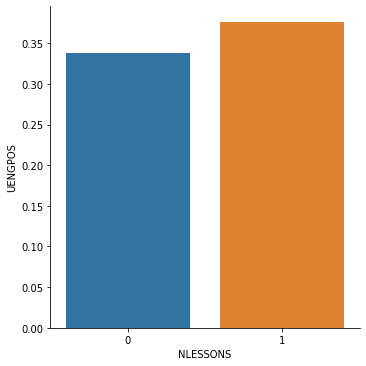

In [36]:
sns.catplot(data=means_L.reset_index(),x='NLESSONS',y='UENGPOS',kind='bar')

**PS with `PRECARIOUS` as treatment**

In [37]:
# logistic regression for precarious
# NB removed UBPIA BHLTHN UENG
predictors= ['SEX','UAGE','UREGION','UMHIGDEG','UHHCOUNT','MNBEDRMS',
             'OVERCROWDING','BDISBL','CSPECED','UACT','CSPECED','UHINS4']
df_prec = df_NN(fc23_prec,'precarious',predictors)

log_model_prec = 'precarious ~ SEX + UAGE + UREGION + UMHIGDEG\
+ UHHCOUNT + MNBEDRMS + OVERCROWDING + BDISBL + CSPECED + UACT + CSPECED + UHINS4'

log_prec = smf.logit(formula=log_model_prec, data=df_prec)
res_prec = log_prec.fit()
res_prec.summary()

Optimization terminated successfully.
         Current function value: 0.357018
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                21341
Model:                          Logit   Df Residuals:                    21327
Method:                           MLE   Df Model:                           13
Date:                Sun, 13 Dec 2020   Pseudo R-squ.:                  0.3154
Time:                        11:52:00   Log-Likelihood:                -7619.1
converged:                       True   LL-Null:                       -11130.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6419      0.209      3.074      0.002       0.233       1.051
UREGION[T.2]    -0.3597      0.062     -5.796      0.000      -0.481      -0.238
UREGION[T.3]    -0.0024      0.058     -0.041      0.967      -0.116       0.112
UREGION[T.4]    -0.1856      0.062     -3.007      0.003      -0.307      -0.065
SEX              0.1692      0.042      4.056      0.000       0.087       0.251
UAGE             0.0123      0.006      2.066      0.039       0.001       0.024
UMHIGDEG        -0.0142      0.011     -1.343      0.179      -0.035       0.007
UHHCOUNT        -0.0230      0.034     -0.686      0.492      -0.089       0.043
MNBEDRMS        -0.7317      0.054    -13.648      0.000      -0.837      -0.627
OVERCROWDING     0.2089      0.080      2.618      0.009       0.053       0.365
BDISBL          -0.5446      0.066     -8.217      0.000      -0.674      -0.415
CSPECED         -0.3042      0.067     -4.565      0.000      -0.435      -0.174
UACT            -0.3996      0.023    -17.436      0.000      -0.445      -0.355
UHINS4           1.2061      0.022     55.383      0.000       1.163       1.249
================================================================================
"""

In [38]:
pred_prec = res_prec.predict(df_prec)
df_prec.loc[:,'PS'] = pred_prec

//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
//anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


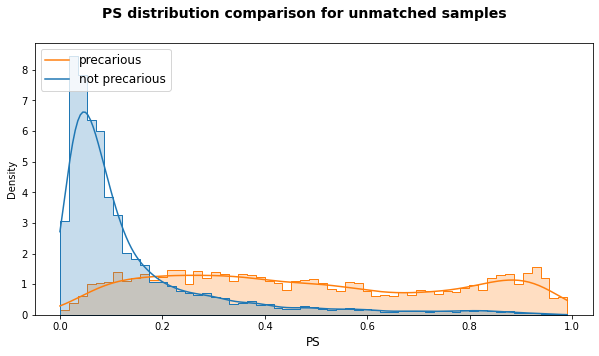

In [39]:
# Plot PS for unmatched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_prec, x="PS", hue='precarious', kde=True, element='step', stat='density',
             common_norm=False)
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper left', fontsize = 12)
plt.show()

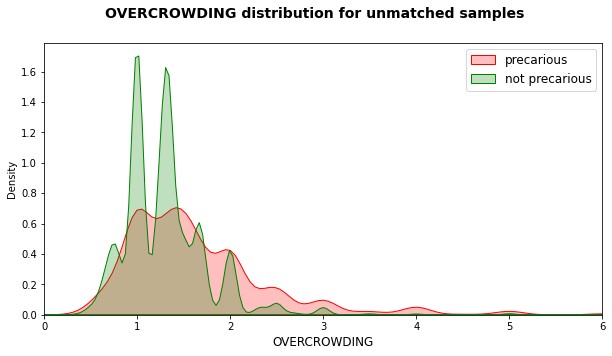

In [40]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for unmatched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_prec, x=var, hue='precarious', palette=['g','r'], shade=True, common_norm=False)
plt.xlim(0,6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for unmatched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

In [41]:
means_prec = df_prec.groupby('precarious').mean()
print('Diff of mean = ' +str(means_prec['UENGPOS'][0] - means_prec['UENGPOS'][1]))
means_prec

Diff of mean = 0.12277064220659642


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,NLESSONS,UFAMSTR,UMH2,UMHIGDEG,...,QSC5,MNBEDRMS,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,bool0_5,PS
precarious,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.488408,11.556704,12.794993,0.188934,0.339926,0.365141,3.456740,80.787225,3.681405,...,0.639221,3.384620,1.153740,1.300079,0.727270,0.153457,-0.092679,-0.075122,0.260755,0.141871
1,2.0,0.501412,11.453420,11.756352,0.313138,0.217155,0.226493,2.244083,73.281868,3.717264,...,0.087948,2.749186,1.796743,1.647622,0.637622,0.275461,-0.116033,-0.129931,0.361346,0.484397


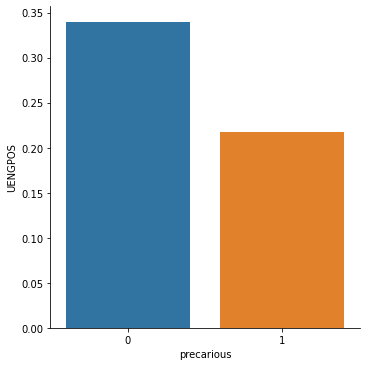

In [42]:
sns.catplot(data=means_prec.reset_index(),x='precarious',y='UENGPOS',kind='bar')

In [43]:
# Perform matching
trtm_prec = df_prec[df_prec.precarious == 1].reset_index(drop=True)
ctrl_prec = df_prec[df_prec.precarious == 0].reset_index(drop=True)

# Perform matching between treated and non-treated papers
df_prec = optimatch(ctrl_prec,trtm_prec,0.001)

print(f'Number of treated subjects (precarious) : {trtm_prec.shape[0]} \n\
Number of control subjects (not precarious) : {ctrl_prec.shape[0]} \n\
Number of matched pairs : {df_prec.shape[0]/2}')

Number of treated subjects (precarious) : 4605 
Number of control subjects (not precarious) : 16736 
Number of matched pairs : 3376.0


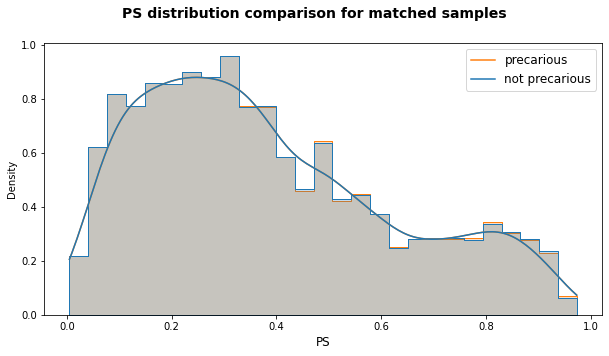

In [44]:
# Plot PS for matched groups
fig = plt.figure(figsize=(10,5))
sns.histplot(data=df_prec, x="PS", hue='precarious', kde=True, element='step', stat='density')
plt.xlabel('PS', fontsize=12)
plt.suptitle('PS distribution comparison for matched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

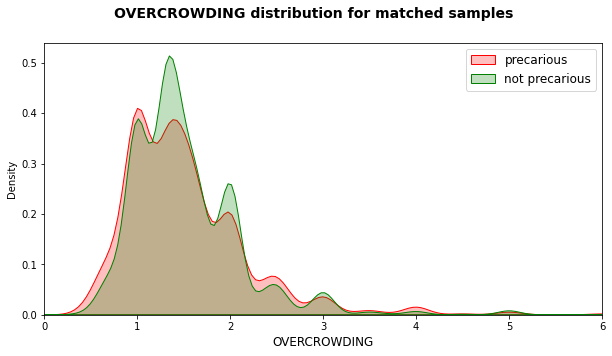

In [45]:
# Plot a seemingly unrelated variable (here OVERCROWDING) for matched groups
var = 'OVERCROWDING'
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=df_prec, x=var, hue='precarious', palette=['g','r'], shade=True)
plt.xlim(0, 6)
plt.xlabel(var, fontsize=12)
plt.suptitle(var+' distribution for matched samples', fontsize=14, fontweight='bold')
plt.legend(['precarious','not precarious'], loc='upper right', fontsize = 12)
plt.show()

In [46]:
means_prec = df_prec.groupby('precarious').mean()
print('Diff of mean = ' +str(means_prec['UENGPOS'][0] - means_prec['UENGPOS'][1]))

Diff of mean = 0.05746445497630334


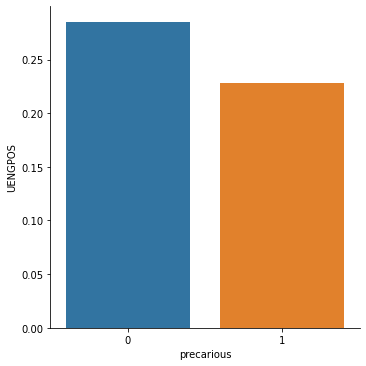

In [47]:
sns.catplot(data=means_prec.reset_index(),x='precarious',y='UENGPOS',kind='bar')

## Linear regression models

In [48]:
# returns a regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit, cluster std based on state        
    return smf.ols(formula=model, data=df_reg).fit(cov_type='cluster',cov_kwds={'groups': df_reg['STATE']})

## Education

In [49]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     1385.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           1.19e-58
Time:                        11:52:11   Log-Likelihood:                -48861.
No. Observations:               21077   AIC:                         9.775e+04
Df Residuals:                   21064   BIC:                         9.785e+04
Df Model:                          12                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.0595      0.276     18.324   

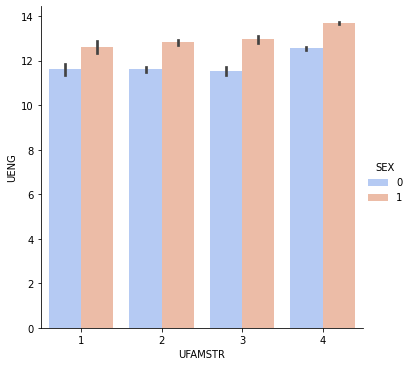

In [50]:
sns.catplot(y='UENG', x='UFAMSTR', hue='SEX', kind='bar', palette='coolwarm', data=df_NN(fc23,outcome,predictors))

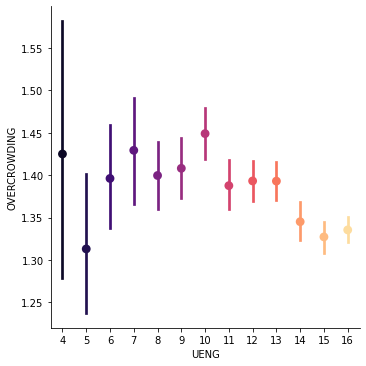

In [51]:
sns.catplot(x='UENG', y='OVERCROWDING',kind='point', palette='magma', data=df_NN(fc23,outcome,predictors))

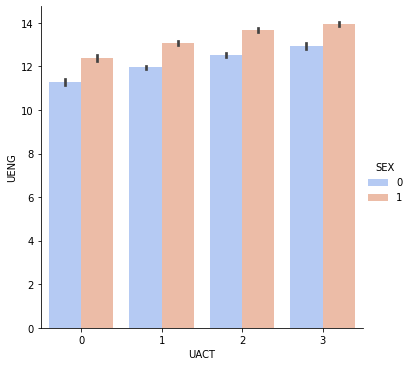

In [52]:
sns.catplot(y='UENG', x='UACT', hue='SEX', kind='bar', palette='coolwarm', data=df_NN(fc23,outcome,predictors))

## Health

In [53]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     258.4
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           4.85e-40
Time:                        11:52:13   Log-Likelihood:                -26914.
No. Observations:               21461   AIC:                         5.385e+04
Df Residuals:                   21449   BIC:                         5.395e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.2293      0.086     37.575   

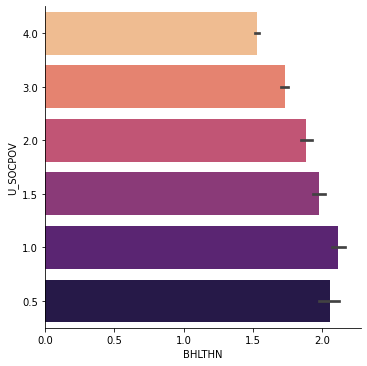

In [54]:
g = sns.catplot(x='BHLTHN', y='U_SOCPOV',kind='bar',palette='magma', data=df_NN(fc23,outcome,predictors), orient='h')
g.fig.axes[0].invert_yaxis()
#g.fig.axes[0].invert_xaxis()

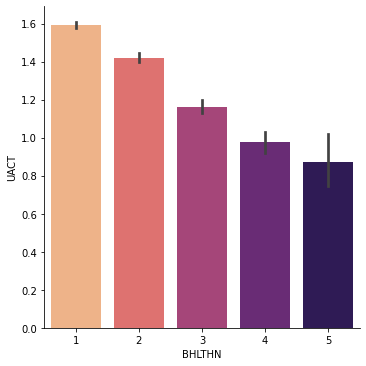

In [55]:
sns.catplot(x='BHLTHN', y='UACT',kind='bar', palette='magma_r', data=df_NN(fc23,outcome,predictors))

## Mental health


**fc2**


In [56]:
outcome = 'UBPIA'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     598.6
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           4.88e-49
Time:                        11:52:15   Log-Likelihood:                -21285.
No. Observations:               10583   AIC:                         4.259e+04
Df Residuals:                   10571   BIC:                         4.268e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.7844      0.220     35.364   

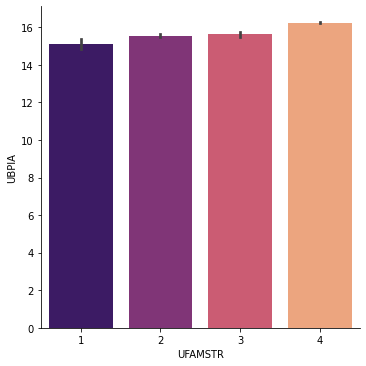

In [57]:
sns.catplot(y='UBPIA', x='UFAMSTR', kind='bar', palette='magma', data=df_NN(fc2,outcome,predictors))

**fc3**

In [58]:
outcome = 'UBPIB'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc3,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     668.4
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           3.16e-50
Time:                        11:52:15   Log-Likelihood:                -21992.
No. Observations:               10784   AIC:                         4.401e+04
Df Residuals:                   10772   BIC:                         4.410e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7996      0.329     17.615   

In [59]:
df_noNull = df_NN(fc3,outcome, predictors)
xtest = df_noNull[predictors]
diff = (res.predict(xtest) - df_noNull['UBPIB'])
print(diff.mean(),diff.std())
#error is normally distributed -> good, but the low r squared gives a rather high std

-6.4020664799823936e-15 1.859725625210495


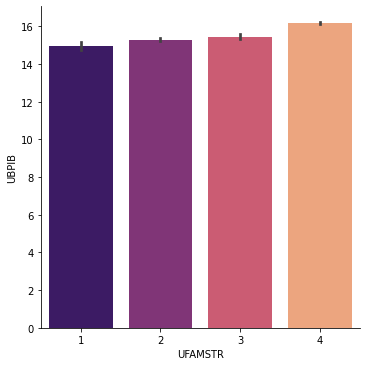

In [60]:
sns.catplot(y='UBPIB', x='UFAMSTR', kind='bar', palette='magma', data=df_NN(fc3,outcome,predictors))

## Conclusion Q1

Looking at the whole model, we can say that mental health is most influenced by housing conditions.

## Mental health of UMH2

In [61]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     44.53
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           2.55e-19
Time:                        11:52:16   Log-Likelihood:            -1.3349e+05
No. Observations:               33553   AIC:                         2.670e+05
Df Residuals:                   33545   BIC:                         2.671e+05
Df Model:                           7                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       72.4220      0.783     92.483   

## Average treatment effect on schooling, health & happiness

Using the matched pairs we can compute the average treatment (young child and precarity) effect on our variables of interest.

__ATE of having a young child (or children) in the household__

In [62]:
# Computes CI
def CI(alpha, data):    
    ci = sms.DescrStatsW(data).tconfint_mean(alpha)
#    return '['+ '{:.6f}'.format(round(ci[0],6))+' ; '+ '{:.6f}'.format(round(ci[1],6))+']'
    return ci

In [63]:
# computes and returns the significance (***=1%, **=5%, *=10%)
def stars(ci):
    if np.sign(ci[2][0]) == np.sign(ci[2][1]):
        return '***'
    elif np.sign(ci[1][0]) == np.sign(ci[1][1]):
        return '**'
    elif np.sign(ci[0][0]) == np.sign(ci[0][1]):
        return '*'
    else:
        return 'Not significant'

In [64]:
# Computes average treatment effect of 'treatment_var' on the variable of interest 'voi'
def ATE (data, treatment_var, voi):
    # keep only valid data for voi (no NaNs)
    df = df_NN(data,treatment_var,[voi])
    # perform matching
    treated = df[df[treatment_var] == 1].reset_index(drop=True)
    control = df[df[treatment_var] == 0].reset_index(drop=True)
    df_match = optimatch(treated,control,0.001)
    print(f'Number of matched subjects: {df_match.shape[0]} / {df.shape[0]}')

    pairs_difference = df_match.loc[df_match[treatment_var]==1,voi].values - df_match.loc[df_match[treatment_var]==0,voi].values
    
    ate = sum(pairs_difference)/pairs_difference.size
    ci = [ CI(0.1, pairs_difference), CI(0.05, pairs_difference), CI(0.01, pairs_difference)]
    star = stars(ci)
    
    return ate, ci, star

In [65]:
# Computes ATE of 'treatment_var' on several variables of interest listed in 'list_voi'
# Returns a dataframe with the variables and their ATE
def multiple_ATE (data, treatment_var, list_voi):
    ates = []
    stars = []
    ci90 = []
    ci95 = []
    ci99 = []
    
    for var in list_voi:
        print(var)
        ate, ci, star = ATE(data, treatment_var, var)
        ates.append(ate)
        stars.append(star)
        ci90.append(ci[0])
        ci95.append(ci[1])
        ci99.append(ci[2])
        
    df_ate = pd.DataFrame({'variable': list_voi, 'ATE': ates, 'ci90': ci90, 'ci95': ci95, 'ci99': ci99,
                           'Significance': stars})
    
    # nice display of confidence intervals
    for i in range(3):
        col = ['ci90','ci95','ci99']
        col_fmd = ['90% CI','95% CI','99% CI']
        df_ate.loc[:,col_fmd[i]] = df_ate[col[i]].apply(lambda x : '['+ '{:.6f}'.format(x[0],6)+' ; '+ '{:.6f}'.format(x[1],6)+']')
    
    # ATE significance at the 95% level (positive or negative)
    df_ate.loc[:,'sig95'] = df_ate['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + df_ate['ATE'].apply(lambda x : 1 if x > 0 else 0)
    df_ate['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
    
    return df_ate

In [66]:
# Returns dataframe with variables of interest in this study with their confidence intervals and significance
def ATE_sch_hlth_happ (data, treatment_var,fc2=False,fc3=False):
    ate = multiple_ATE(data, treatment_var, ['UENGn','UENGNEG','UENGPOS','BHLTHNn'])
    if (fc2==True):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn','UBPIANEG','UBPIAPOS'])
        return ate.append(ate_ubpia, ignore_index=True)
    if (fc3==True):
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn','UBPIBNEG','UBPIBPOS'])
        return ate.append(ate_ubpib, ignore_index=True)
    if ((fc2==False)and(fc3==False)):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn','UBPIANEG','UBPIAPOS'])
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn','UBPIBNEG','UBPIBPOS'])
        return ate.append(ate_ubpia.append(ate_ubpib,ignore_index=True), ignore_index=True)

In [67]:
# Plots ATEs of 'df' with 'treatment' (must be in ['child05','lessons','precarious'])
def plot_ATE (df, treatment):
    treatment_list = {'child05' : 'having at least one child aged 0-5 in the house',
                      'lessons' : 'taking lessons outside of school',
                      'precarious' : 'precarious living conditions'}
    tr = treatment_list[treatment]
    
    plt.figure(figsize=(10,5))
    groups = df.sort_values('ATE').groupby('sig95', sort=False)
    for sig, group in groups:
        error = group['ci95'].apply(pd.Series).to_numpy()
        length_error = abs(error[:,0] - group.ATE.values)
        plt.errorbar(group.ATE, group.variable, marker='o', ls='', xerr=length_error, capsize=3, elinewidth=1,
                     label=sig)
    plt.axvline(0,color='k',linestyle='--')
    plt.xlabel('ATE (with 95% CI)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Average treatment effect of ' + tr + ' on several variables',
              fontweight='bold', fontsize=14)
    plt.legend()
    plt.show()

In [68]:
ate_05 = ATE_sch_hlth_happ(df_05, 'bool0_5')
ate_05[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 10246 / 21200
UENGNEG
Number of matched subjects: 10250 / 21200
UENGPOS
Number of matched subjects: 10266 / 21200
BHLTHNn
Number of matched subjects: 10380 / 21474
UBPIAn
Number of matched subjects: 6490 / 10587
UBPIANEG
Number of matched subjects: 6502 / 10587
UBPIAPOS
Number of matched subjects: 6492 / 10587
UBPIBn
Number of matched subjects: 2708 / 10785
UBPIBNEG
Number of matched subjects: 2706 / 10785
UBPIBPOS
Number of matched subjects: 2720 / 10785


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,0.009792,[0.002489 ; 0.017096],[0.001089 ; 0.018496],[-0.001647 ; 0.021232],**
1,UENGNEG,-0.016780,[-0.030281 ; -0.003280],[-0.032869 ; -0.000692],[-0.037927 ; 0.004366],**
2,UENGPOS,0.001948,[-0.013202 ; 0.017098],[-0.016105 ; 0.020002],[-0.021781 ; 0.025678],Not significant
3,BHLTHNn,-0.010645,[-0.017899 ; -0.003392],[-0.019289 ; -0.002002],[-0.022006 ; 0.000715],**
4,UBPIAn,-0.011145,[-0.018074 ; -0.004217],[-0.019402 ; -0.002889],[-0.021999 ; -0.000292],***
5,UBPIANEG,0.018148,[0.007975 ; 0.028321],[0.006025 ; 0.030271],[0.002212 ; 0.034084],***
6,UBPIAPOS,-0.022797,[-0.041371 ; -0.004224],[-0.044931 ; -0.000664],[-0.051892 ; 0.006298],**
7,UBPIBn,-0.033112,[-0.044903 ; -0.021320],[-0.047165 ; -0.019058],[-0.051590 ; -0.014633],***
8,UBPIBNEG,0.039172,[0.020204 ; 0.058140],[0.016566 ; 0.061779],[0.009447 ; 0.068898],***
9,UBPIBPOS,-0.052206,[-0.079955 ; -0.024457],[-0.085278 ; -0.019134],[-0.095692 ; -0.008720],***


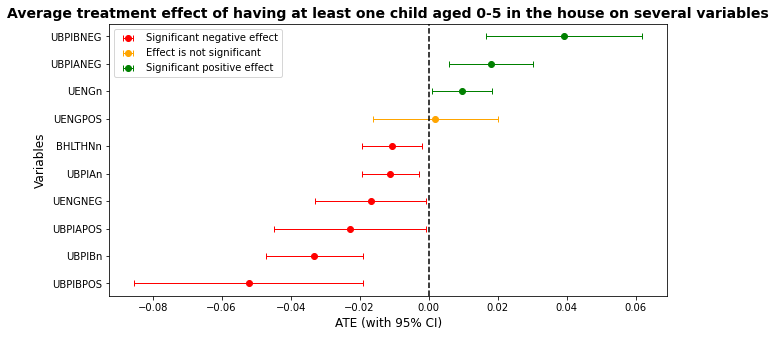

In [69]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red', 'orange', 'green']) 

plot_ATE(ate_05,'child05')

__ATE of taking lessons outside of school__

In [70]:
ate_lessons = ATE_sch_hlth_happ(df_lessons, 'NLESSONS')
ate_lessons[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 13640 / 21056
UENGNEG
Number of matched subjects: 13658 / 21056
UENGPOS
Number of matched subjects: 13654 / 21056
BHLTHNn
Number of matched subjects: 13800 / 21287
UBPIAn
Number of matched subjects: 6494 / 10492
UBPIANEG
Number of matched subjects: 6476 / 10492
UBPIAPOS
Number of matched subjects: 6484 / 10492
UBPIBn
Number of matched subjects: 6514 / 10705
UBPIBNEG
Number of matched subjects: 6500 / 10705
UBPIBPOS
Number of matched subjects: 6512 / 10705


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,0.029778,[0.023972 ; 0.035583],[0.022860 ; 0.036696],[0.020685 ; 0.038870],***
1,UENGNEG,-0.056817,[-0.067531 ; -0.046102],[-0.069584 ; -0.044049],[-0.073598 ; -0.040035],***
2,UENGPOS,0.032371,[0.019080 ; 0.045662],[0.016534 ; 0.048209],[0.011555 ; 0.053188],***
3,BHLTHNn,-0.021413,[-0.027193 ; -0.015633],[-0.028301 ; -0.014525],[-0.030466 ; -0.012360],***
4,UBPIAn,-0.006185,[-0.012645 ; 0.000275],[-0.013883 ; 0.001513],[-0.016304 ; 0.003934],Not significant
5,UBPIANEG,-0.007721,[-0.016964 ; 0.001523],[-0.018736 ; 0.003294],[-0.022200 ; 0.006759],Not significant
6,UBPIAPOS,-0.038865,[-0.057075 ; -0.020655],[-0.060565 ; -0.017164],[-0.067390 ; -0.010339],***
7,UBPIBn,0.023488,[0.016726 ; 0.030250],[0.015430 ; 0.031546],[0.012895 ; 0.034081],***
8,UBPIBNEG,-0.027385,[-0.037669 ; -0.017100],[-0.039640 ; -0.015129],[-0.043495 ; -0.011274],***
9,UBPIBPOS,0.028563,[0.010352 ; 0.046773],[0.006861 ; 0.050264],[0.000036 ; 0.057089],***


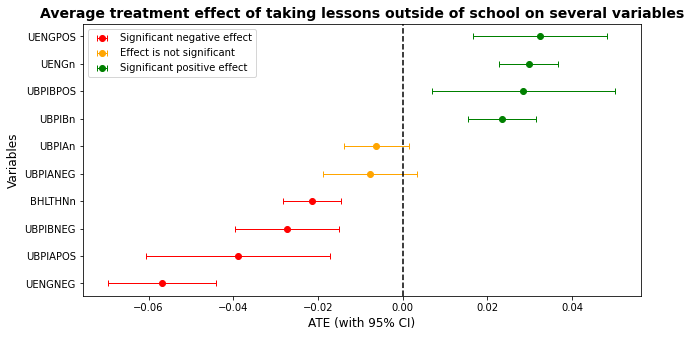

In [71]:
plot_ATE(ate_lessons,'lessons')

__ATE of precarious household__

In [72]:
ate_precarious = ATE_sch_hlth_happ(df_prec, 'precarious')
ate_precarious[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 6454 / 6670
UENGNEG
Number of matched subjects: 6458 / 6670
UENGPOS
Number of matched subjects: 6454 / 6670
BHLTHNn
Number of matched subjects: 6586 / 6752
UBPIAn
Number of matched subjects: 2818 / 3478
UBPIANEG
Number of matched subjects: 2836 / 3478
UBPIAPOS
Number of matched subjects: 2842 / 3478
UBPIBn
Number of matched subjects: 2644 / 3241
UBPIBNEG
Number of matched subjects: 2622 / 3241
UBPIBPOS
Number of matched subjects: 2632 / 3241


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.048187,[-0.057905 ; -0.038470],[-0.059767 ; -0.036607],[-0.063410 ; -0.032965],***
1,UENGNEG,0.082998,[0.064611 ; 0.101385],[0.061086 ; 0.104909],[0.054195 ; 0.111801],***
2,UENGPOS,-0.053300,[-0.071664 ; -0.034936],[-0.075184 ; -0.031417],[-0.082067 ; -0.024534],***
3,BHLTHNn,0.063468,[0.053293 ; 0.073643],[0.051342 ; 0.075594],[0.047529 ; 0.079407],***
4,UBPIAn,-0.056186,[-0.067829 ; -0.044544],[-0.070062 ; -0.042311],[-0.074431 ; -0.037942],***
5,UBPIANEG,0.057828,[0.039276 ; 0.076379],[0.035718 ; 0.079938],[0.028756 ; 0.086900],***
6,UBPIAPOS,-0.114004,[-0.140364 ; -0.087645],[-0.145420 ; -0.082589],[-0.155312 ; -0.072697],***
7,UBPIBn,-0.059128,[-0.072091 ; -0.046164],[-0.074578 ; -0.043677],[-0.079444 ; -0.038812],***
8,UBPIBNEG,0.057208,[0.035355 ; 0.079061],[0.031163 ; 0.083253],[0.022961 ; 0.091456],***
9,UBPIBPOS,-0.081307,[-0.108384 ; -0.054230],[-0.113579 ; -0.049035],[-0.123742 ; -0.038872],***


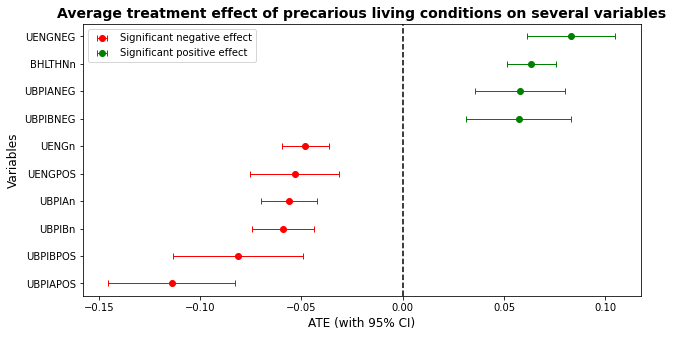

In [73]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red', 'green']) 

plot_ATE(ate_precarious,'precarious')

### 3) fc2 or fc3

In [74]:
ate_precarious_fc2 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] < 12],'precarious',fc2=True)
ate_precarious_fc2[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 2814 / 3465
UENGNEG
Number of matched subjects: 2812 / 3465
UENGPOS
Number of matched subjects: 2826 / 3465
BHLTHNn
Number of matched subjects: 2868 / 3495
UBPIAn
Number of matched subjects: 2848 / 3478
UBPIANEG
Number of matched subjects: 2828 / 3478
UBPIAPOS
Number of matched subjects: 2816 / 3478


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.054075,[-0.067867 ; -0.040283],[-0.070513 ; -0.037637],[-0.075689 ; -0.032461],***
1,UENGNEG,0.083926,[0.058589 ; 0.109263],[0.053729 ; 0.114123],[0.044221 ; 0.123631],***
2,UENGPOS,-0.053786,[-0.082939 ; -0.024633],[-0.088531 ; -0.019042],[-0.099471 ; -0.008101],***
3,BHLTHNn,0.058403,[0.043686 ; 0.073120],[0.040863 ; 0.075943],[0.035340 ; 0.081466],***
4,UBPIAn,-0.052551,[-0.064124 ; -0.040979],[-0.066344 ; -0.038759],[-0.070687 ; -0.034416],***
5,UBPIANEG,0.058699,[0.039918 ; 0.077479],[0.036316 ; 0.081082],[0.029268 ; 0.088130],***
6,UBPIAPOS,-0.117188,[-0.143639 ; -0.090736],[-0.148713 ; -0.085662],[-0.158640 ; -0.075735],***


In [75]:
ate_precarious_fc3 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] >= 12],'precarious',fc3=True)
ate_precarious_fc3[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 2614 / 3205
UENGNEG
Number of matched subjects: 2620 / 3205
UENGPOS
Number of matched subjects: 2612 / 3205
BHLTHNn
Number of matched subjects: 2656 / 3257
UBPIBn
Number of matched subjects: 2650 / 3241
UBPIBNEG
Number of matched subjects: 2626 / 3241
UBPIBPOS
Number of matched subjects: 2636 / 3241


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.037427,[-0.053642 ; -0.021212],[-0.056752 ; -0.018101],[-0.062839 ; -0.012015],***
1,UENGNEG,0.073282,[0.042985 ; 0.103580],[0.037173 ; 0.109392],[0.025801 ; 0.120763],***
2,UENGPOS,-0.055130,[-0.083437 ; -0.026824],[-0.088867 ; -0.021393],[-0.099491 ; -0.010769],***
3,BHLTHNn,0.063441,[0.047467 ; 0.079415],[0.044403 ; 0.082479],[0.038408 ; 0.088475],***
4,UBPIBn,-0.059057,[-0.072041 ; -0.046072],[-0.074532 ; -0.043582],[-0.079405 ; -0.038708],***
5,UBPIBNEG,0.058644,[0.037196 ; 0.080092],[0.033082 ; 0.084207],[0.025032 ; 0.092257],***
6,UBPIBPOS,-0.084977,[-0.111903 ; -0.058052],[-0.117068 ; -0.052886],[-0.127174 ; -0.042780],***


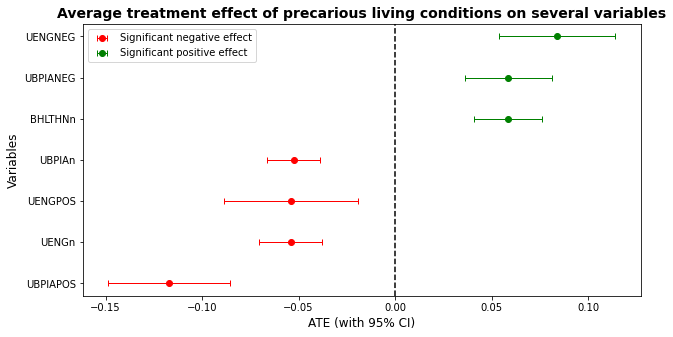

In [76]:
plot_ATE(ate_precarious_fc2,'precarious')

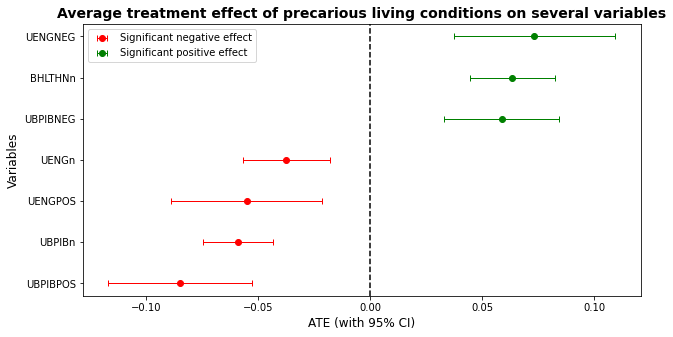

In [77]:
plot_ATE(ate_precarious_fc3,'precarious')

In [78]:
age_diff = pd.DataFrame(ate_precarious_fc3.variable)
ci90s = []
ci95s = []
ci99s = []
for i in range (0,7):
    ate = ate_precarious_fc3['ATE'][i] - ate_precarious_fc2['ATE'][i]
    age_diff.loc[i,'ATE'] = ate
    
    #ci qui est la diff des coordonnées des ci de fc2 et fc3 : 
    ci=[(ate_precarious_fc3['ci90'][i][0] - ate_precarious_fc2['ci90'][i][0],ate_precarious_fc3['ci90'][i][1] - ate_precarious_fc2['ci90'][i][1]),(ate_precarious_fc3['ci95'][i][0] - ate_precarious_fc2['ci95'][i][0],ate_precarious_fc3['ci95'][i][1] - ate_precarious_fc2['ci95'][i][1]),(ate_precarious_fc3['ci99'][i][0] - ate_precarious_fc2['ci99'][i][0],ate_precarious_fc3['ci99'][i][1] - ate_precarious_fc2['ci99'][i][1])]
   
    #ci qui utilise la même taille de ci que les précédents (assez grands du coup rien n'est significant) : 
    #ci = [(ate_precarious_fc3['ci90'][i][0]-ate_precarious_fc3['ATE'][i]+ate,ate_precarious_fc3['ci90'][i][1]-ate_precarious_fc3['ATE'][i]+ate),(ate_precarious_fc3['ci95'][i][0]-ate_precarious_fc3['ATE'][i]+ate,ate_precarious_fc3['ci95'][i][1]-ate_precarious_fc3['ATE'][i]+ate),(ate_precarious_fc3['ci99'][i][0]-ate_precarious_fc3['ATE'][i]+ate,ate_precarious_fc3['ci99'][i][1]-ate_precarious_fc3['ATE'][i]+ate)]
    
    ci90s.append(ci[0])
    ci95s.append(ci[1])
    ci99s.append(ci[2])
    age_diff.loc[i,'Significance'] = stars(ci)
    age_diff.loc[:,'sig95'] = age_diff['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + age_diff['ATE'].apply(lambda x : 1 if x > 0 else 0)
    age_diff['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
age_diff['ci90'] = ci90s
age_diff['ci95'] = ci95s
age_diff['ci99'] = ci99s

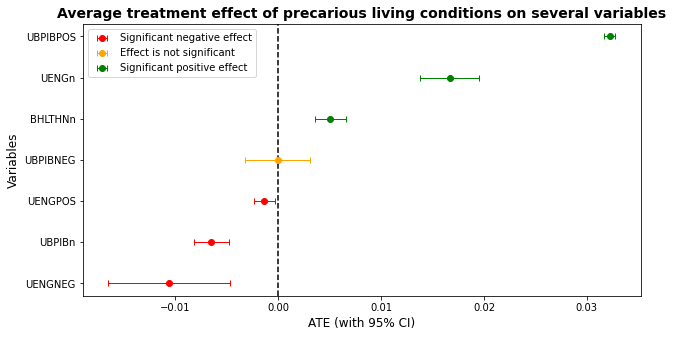

In [79]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red', 'orange', 'green']) 

plot_ATE(age_diff,'precarious')

#### fc3 - fc2 pour les valeurs, aucune des deux méthodes de CI me convient mais la première donne un meilleur truc (visuellement en tt cas) \\
     Plus le point est à adroite, + la variable en question est impactée par la précarité pour les 12-17. Plus c'est à gauche, plus la variable en question est impactée par la précarité pour les 6-11.

### Effect of family structure

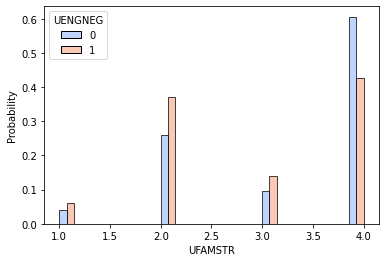

In [80]:
sns.histplot(x='UFAMSTR', hue='UENGNEG', stat='probability', data=df_NN(fc23,'UENGNEG', ['UFAMSTR']),
             common_norm=False, multiple='dodge', palette='coolwarm')
# dans quelles familles sont distribués les enfants peu engagés

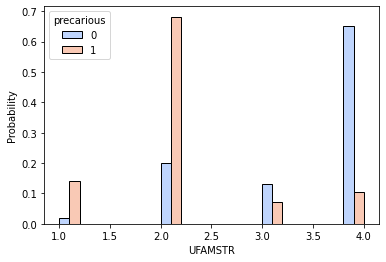

In [81]:
sns.histplot(x='UFAMSTR', hue='precarious', stat='probability', data=df_NN(df_prec,'precarious', ['UFAMSTR']),
             common_norm=False, multiple='dodge', palette='coolwarm')
# dans quelles familles sont distribués les enfants peu engagés

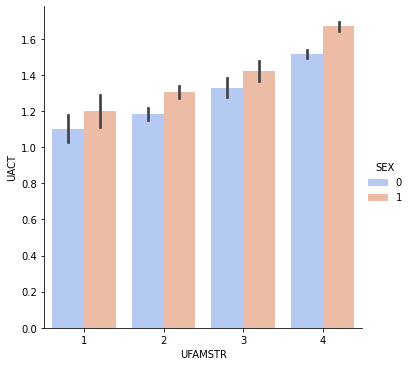

In [82]:
var='UACT'
sns.catplot(x='UFAMSTR', y=var, hue='SEX', kind='bar', palette='coolwarm', data=df_NN(child,var,['UFAMSTR']))
# les gens avec une bonne structure familiale sortent plus + les meufs sortent plus que les gars across all familial structures

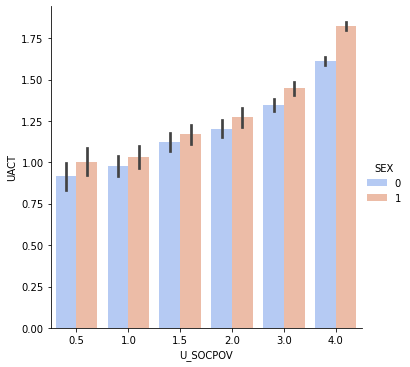

In [83]:
var='UACT'
sns.catplot(x='U_SOCPOV', y=var, hue='SEX', kind='bar', palette='coolwarm', data=df_NN(child,var,['U_SOCPOV']))
# same avec les gens plus aisés

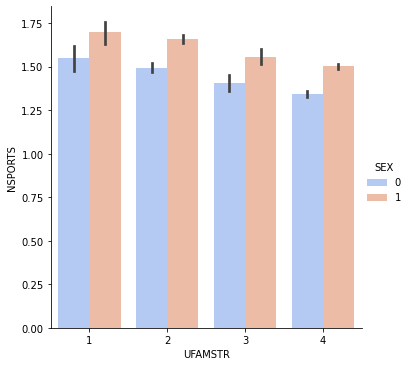

In [84]:
var='NSPORTS'
sns.catplot(x='UFAMSTR', y=var, hue='SEX', kind='bar', palette='coolwarm', data=df_NN(fc2,var,['UFAMSTR']))
# moind de structure = + sportifs, encore une fois les filles ont + tendance à faire partie d'une equipe sportive que les garcons

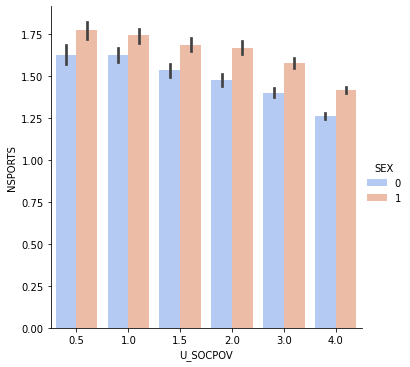

In [85]:
var='NSPORTS'
sns.catplot(x='U_SOCPOV', y=var, hue='SEX', kind='bar', palette='coolwarm', data=df_NN(fc2,var,['U_SOCPOV']))
# plus pauvres plus sportifs, encore une fois les filles ont + tendance à faire partie d'une equipe sportive que les garcons

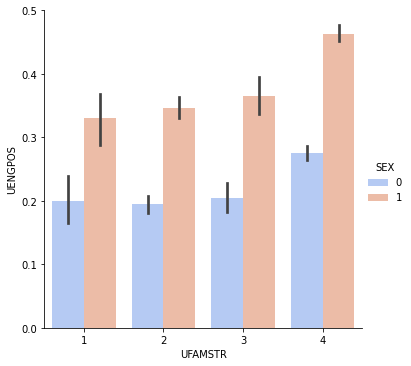

In [86]:
var='UENGPOS'
sns.catplot(x='UFAMSTR', y=var, hue='SEX', kind='bar', palette='coolwarm', data=df_NN(fc23,var,['UFAMSTR']))
# filles + scolaires, plus la structure familiale est confortable, meilleur est l'engagment scolaire positif

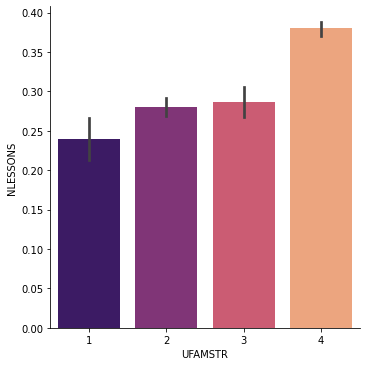

In [87]:
var='NLESSONS'
sns.catplot(x='UFAMSTR', y=var, kind='bar', palette='magma', data=df_NN(child,var,['UFAMSTR']))
# Plus la structure familiale est confortable, + les lessons sont prises

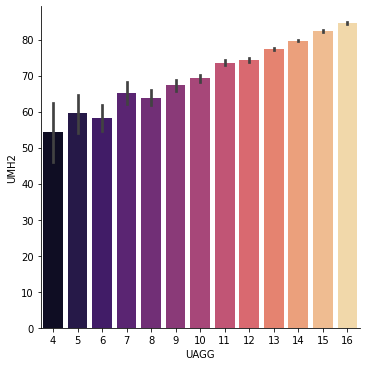

In [88]:
var='UMH2'
sns.catplot(x='UAGG', y=var, kind='bar', palette='magma', data=df_NN(child,var,['UAGG']))
# mental health des parents directement corrélée avec le fait que le gamin soit insupportable (UAGG bas = insupportable)

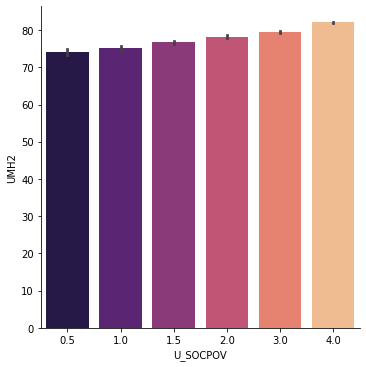

In [89]:
var='UMH2'
sns.catplot(x='U_SOCPOV', y=var, kind='bar', palette='magma', data=df_NN(child,var,['U_SOCPOV']))
# mental health des parents directement corrélée avec l'aisance financière'

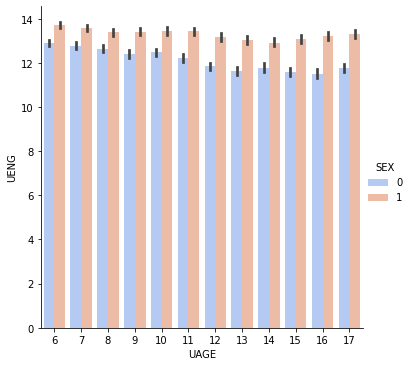

In [90]:
var='UENG'
sns.catplot(x='UAGE', y=var, kind='bar', hue = 'SEX', palette='coolwarm', data=df_NN(fc23,var,['UAGE','SEX']))
# légère baisse de l'eng avec l'age chez les garçons mais pas flagrant (pas certaine de la significance),
# pas significant chez les filles
# UENG ne concerne que fc23

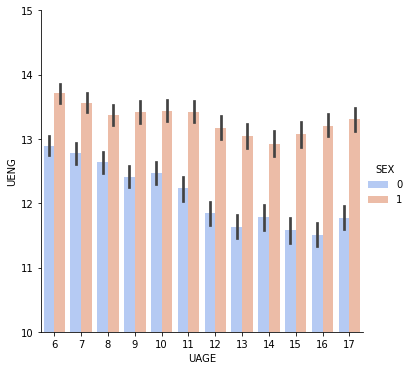

In [91]:
var='UENG'
ax = sns.catplot(x='UAGE', y=var, kind='bar', hue = 'SEX', palette='coolwarm', data=df_NN(fc23,var,['UAGE','SEX']))
ax.set(ylim=(10, 15))
# ZOOM
# légère baisse de l'eng avec l'age chez les garçons vers 12 ans,
# bcp moins significant chez les filles

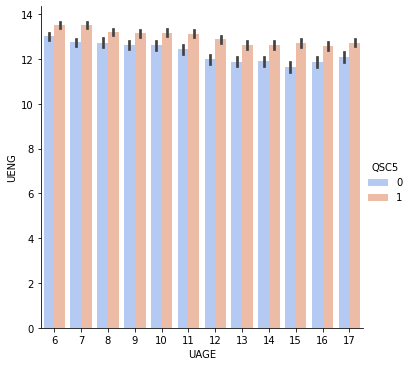

In [92]:
var='UENG'
sns.catplot(x='UAGE', y=var, kind='bar', hue = 'QSC5', palette='coolwarm', data=df_NN(fc23,var,['UAGE','QSC5']))
# engagement à l'école vs age + income (above or below 2x poverty line)
# pas significant chez les filles
# UENG ne concerne que fc23

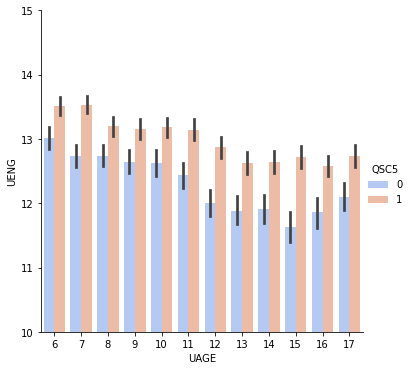

In [93]:
var='UENG'
ax = sns.catplot(x='UAGE', y=var, kind='bar', hue = 'QSC5', palette='coolwarm', data=df_NN(fc23,var,['UAGE','QSC5']))
ax.set(ylim=(10,15))
# ZOOM
# baisse de l'engagement vers 12 ans, plus significant chez les plus pauvres
